In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import time
import tqdm

from matplotlib import cm
from matplotlib.colors import Normalize
import networkx as nx

# Define functions

In [2]:
def phosphorylation_order(dirpath, file_suffix, ser_l, n_sims):
    """
    Calculates the phosphorylation order between serine residues across multiple simulations.
    
    Args:
        dirpath (str): Directory path containing simulation files.
        file_suffix (str): Common suffix of the filenames to be loaded.
        ser_l (np.ndarray): List of serine indices to consider.
        n_sims (int): Number of simulations to analyze.

    Returns:
        np.ndarray: Matrix indicating the phosphorylation order between serines.
    """
    phospho_rank = np.zeros((len(ser_l),len(ser_l)), dtype=int)

    for s in range(n_sims):
        c_tmp = np.loadtxt(dirpath+f"sim{s+1}_{file_suffix}", ndmin=2)

        # Proceed only if there's contacts
        if len(c_tmp)!=0:
            # Filter out phosphorylation events (type=1) and get serine indices
            ph_tmp = c_tmp[c_tmp[:, 2] == 1][:, 1]
            
            for i,ns in enumerate(ser_l):
                # Check if the current serine `ns` has phosphorylation data
                if np.any(ph_tmp == ns):
                    tmp_pos = np.where(ph_tmp == ns)[0][0]  # Time position of the first phosphorylation
                else:
                    tmp_pos = len(ph_tmp)  # If not found, assume it's phosphorylated last

                # Update the phosphorylation order for all serines phosphorylated before `ns`
                for j in range(tmp_pos):
                    prev_ser = ph_tmp[j]       # Serine phosphorylated before `ns`
                    prev_ind = np.where(ser_l==prev_ser)[0][0]  # Index of that serine in `ser_l`
                    phospho_rank[23-i][prev_ind] += 1      # Increment phosphorylation order

    return phospho_rank

In [24]:
def phosphorylation_position(dirpath, file_suffix, ser_l, n_sims):
    """
    Determines the phosphorylation order positions of specific serine residues across multiple simulations.
    
    Args:
        dirpath (str): Directory path containing simulation files.
        file_suffix (str): Common suffix of the filenames to be loaded.
        ser_l (np.ndarray): List of serine indices to consider.
        n_sims (int): Number of simulations to analyze.

    Returns:
        np.ndarray: Array where each element represents the phosphorylation position of a serine 
                    residue across multiple simulations. If no phosphorylation occurs, a default value 
                    (number of serines + 2) is assigned.
    """
    n_sers = len(ser_l)
    phospho_pos = np.empty((n_sers,n_sims), dtype=int)

    for i in range(n_sims):
        c_tmp = np.loadtxt(dirpath+f"sim{i+1}_{file_suffix}", ndmin=2)
        if len(c_tmp)!=0:
            # Filter out phosphorylation events (type = 1) and extract serine indices
            ph_tmp = c_tmp[np.where(c_tmp[:,2]==1)][:,1]
            for j,ns in enumerate(ser_l):
                # Check if the serine `ns` has phosphorylation data
                if len(np.nonzero(ph_tmp==ns)[0]!=0):
                    phospho_pos[j][i] = np.nonzero(ph_tmp==ns)[0][0]  # First phosphorylation occurrence
                else:
                    phospho_pos[j][i] = n_sers+2    # Default value if serine is not phosphorylated
        else:
            for j,ns in enumerate(ser_l):
                phospho_pos[j][i] = n_sers+2
    return phospho_pos

Define path to data

In [38]:
path="/media/zippoema/Elements/zippo_phd_data/single-tdp43/data_hps-cp-r/"

path_b30 = path+"sims_sh_b30_32b/"
path_h_b30 = path+"sims_sh_homo_b30_32b/"
path_hequi_b30 = path+"sims_sh_homo-equiSER_b30_32b/"
path_f_b30 = path+"sims_sh_full_b30_32b/"


Define Ser residues IDs

In [5]:
ser_i = np.array([266, 273, 292, 305, 317, 332, 333, 342, 347, 350, 369, 373, 375, 377, 379, 387, 389, 393, 395, 403, 404, 407, 409, 410])-260 
ser_i_full = ser_i+121 
ser_i_equi = np.linspace(8, 146, 24, dtype=int)
n_ser = len(ser_i)

### Compute phospho rank

In [6]:
ph_rank = phosphorylation_order(dirpath=path_b30, file_suffix='short_ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100)

ph_rank_h = phosphorylation_order(dirpath=path_h_b30, file_suffix='short_ck1d-rigid-rescaled_homotdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100)

ph_rank_f = phosphorylation_order(dirpath=path_f_b30, file_suffix='short_full-ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i_full, n_sims=100)


In [31]:
ph_pos = phosphorylation_position(dirpath=path_b30, file_suffix='short_ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100)

ph_pos_h = phosphorylation_position(dirpath=path_h_b30, file_suffix='short_ck1d-rigid-rescaled_homotdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i, n_sims=100)

ph_pos_f = phosphorylation_position(dirpath=path_f_b30, file_suffix='short_full-ck1d-rigid-rescaled_tdp43_b30_32b_contacts.txt',
                                                  ser_l=ser_i_full, n_sims=100)


# Plots

In [32]:
def circle_xy(n_step=50, R=1):
    
    n = int(n_step/2)
    step = 2*R/n
    y = np.arange(-R+2*R/n,R,step)
    y_new = np.append(y, [y[-1]+1.5*R/n])
    y_inv = y_new[::-1]
    x_minus = -np.sqrt(1 - y_new*y_new)
    x_plus = np.sqrt(1 - y_inv*y_inv)
    x = np.append(x_minus, x_plus)
    x = np.reshape(x, (2*n,1))
    y = np.append(y_new, y_inv)
    y = np.reshape(y, (2*n,1))
    
    return np.append(x,y,axis=1)
    

In [36]:
def plot_hist_network(phospho_pos, ser_l, ser_idx, title=None, save=None):

    ser_id = ser_l[ser_idx]+260
    n_sers = len(ser_l)

    counts_pos, bins_pos = np.histogram(phospho_pos[ser_idx], bins=[i-0.5 for i in range(n_sers+4)])
    counts_pos = np.append(counts_pos[:n_sers], [50])

    # Create a directed graph
    G = nx.DiGraph()
    F = nx.DiGraph()

    # Add nodes
    G.add_nodes_from(range(n_sers+1))
    F.add_nodes_from(range(n_sers+1))

    # Add edges according to the described connections
    for i in range(n_sers):
        G.add_edge(i, i+1)

    for i in range(n_sers):
        G.add_edge(i, n_sers)
    for i in range(n_sers):
        F.add_edge(i, n_sers)

    # positions
    positions = circle_xy(n_sers+2)[1:]
    pos_dict = dict()
    label_dict = dict()
    for i in range(n_sers):
        pos_dict[i] = positions[i]
        label_dict[i] = f"{i}p"
    pos_dict[n_sers] = (0,0)
    label_dict[n_sers] = f"pS{ser_id}"
    
    # Plot the graph
    plt.figure(figsize=(5,6))
    pos=nx.spectral_layout(G)
    nx.draw(G, pos_dict, with_labels=True, labels=label_dict , arrowsize=15, node_color='lightblue', node_size=[600 for i in range(n_sers)]+[2000], font_size=12, width=0.3)
    nx.draw(F, pos_dict, with_labels=True, labels=label_dict , arrowsize=15, node_color='lightblue', node_size=20, font_size=0, width=counts_pos[:-1]/2.5 )
    
    if title is not None:
        plt.title(title)
    if save is not None:
        plt.savefig(save)
        
    plt.show()

In [7]:
plt.style.use('default')
plt.style.use('/localscratch/zippoema/md_plots/corr_plot.mplstyle')


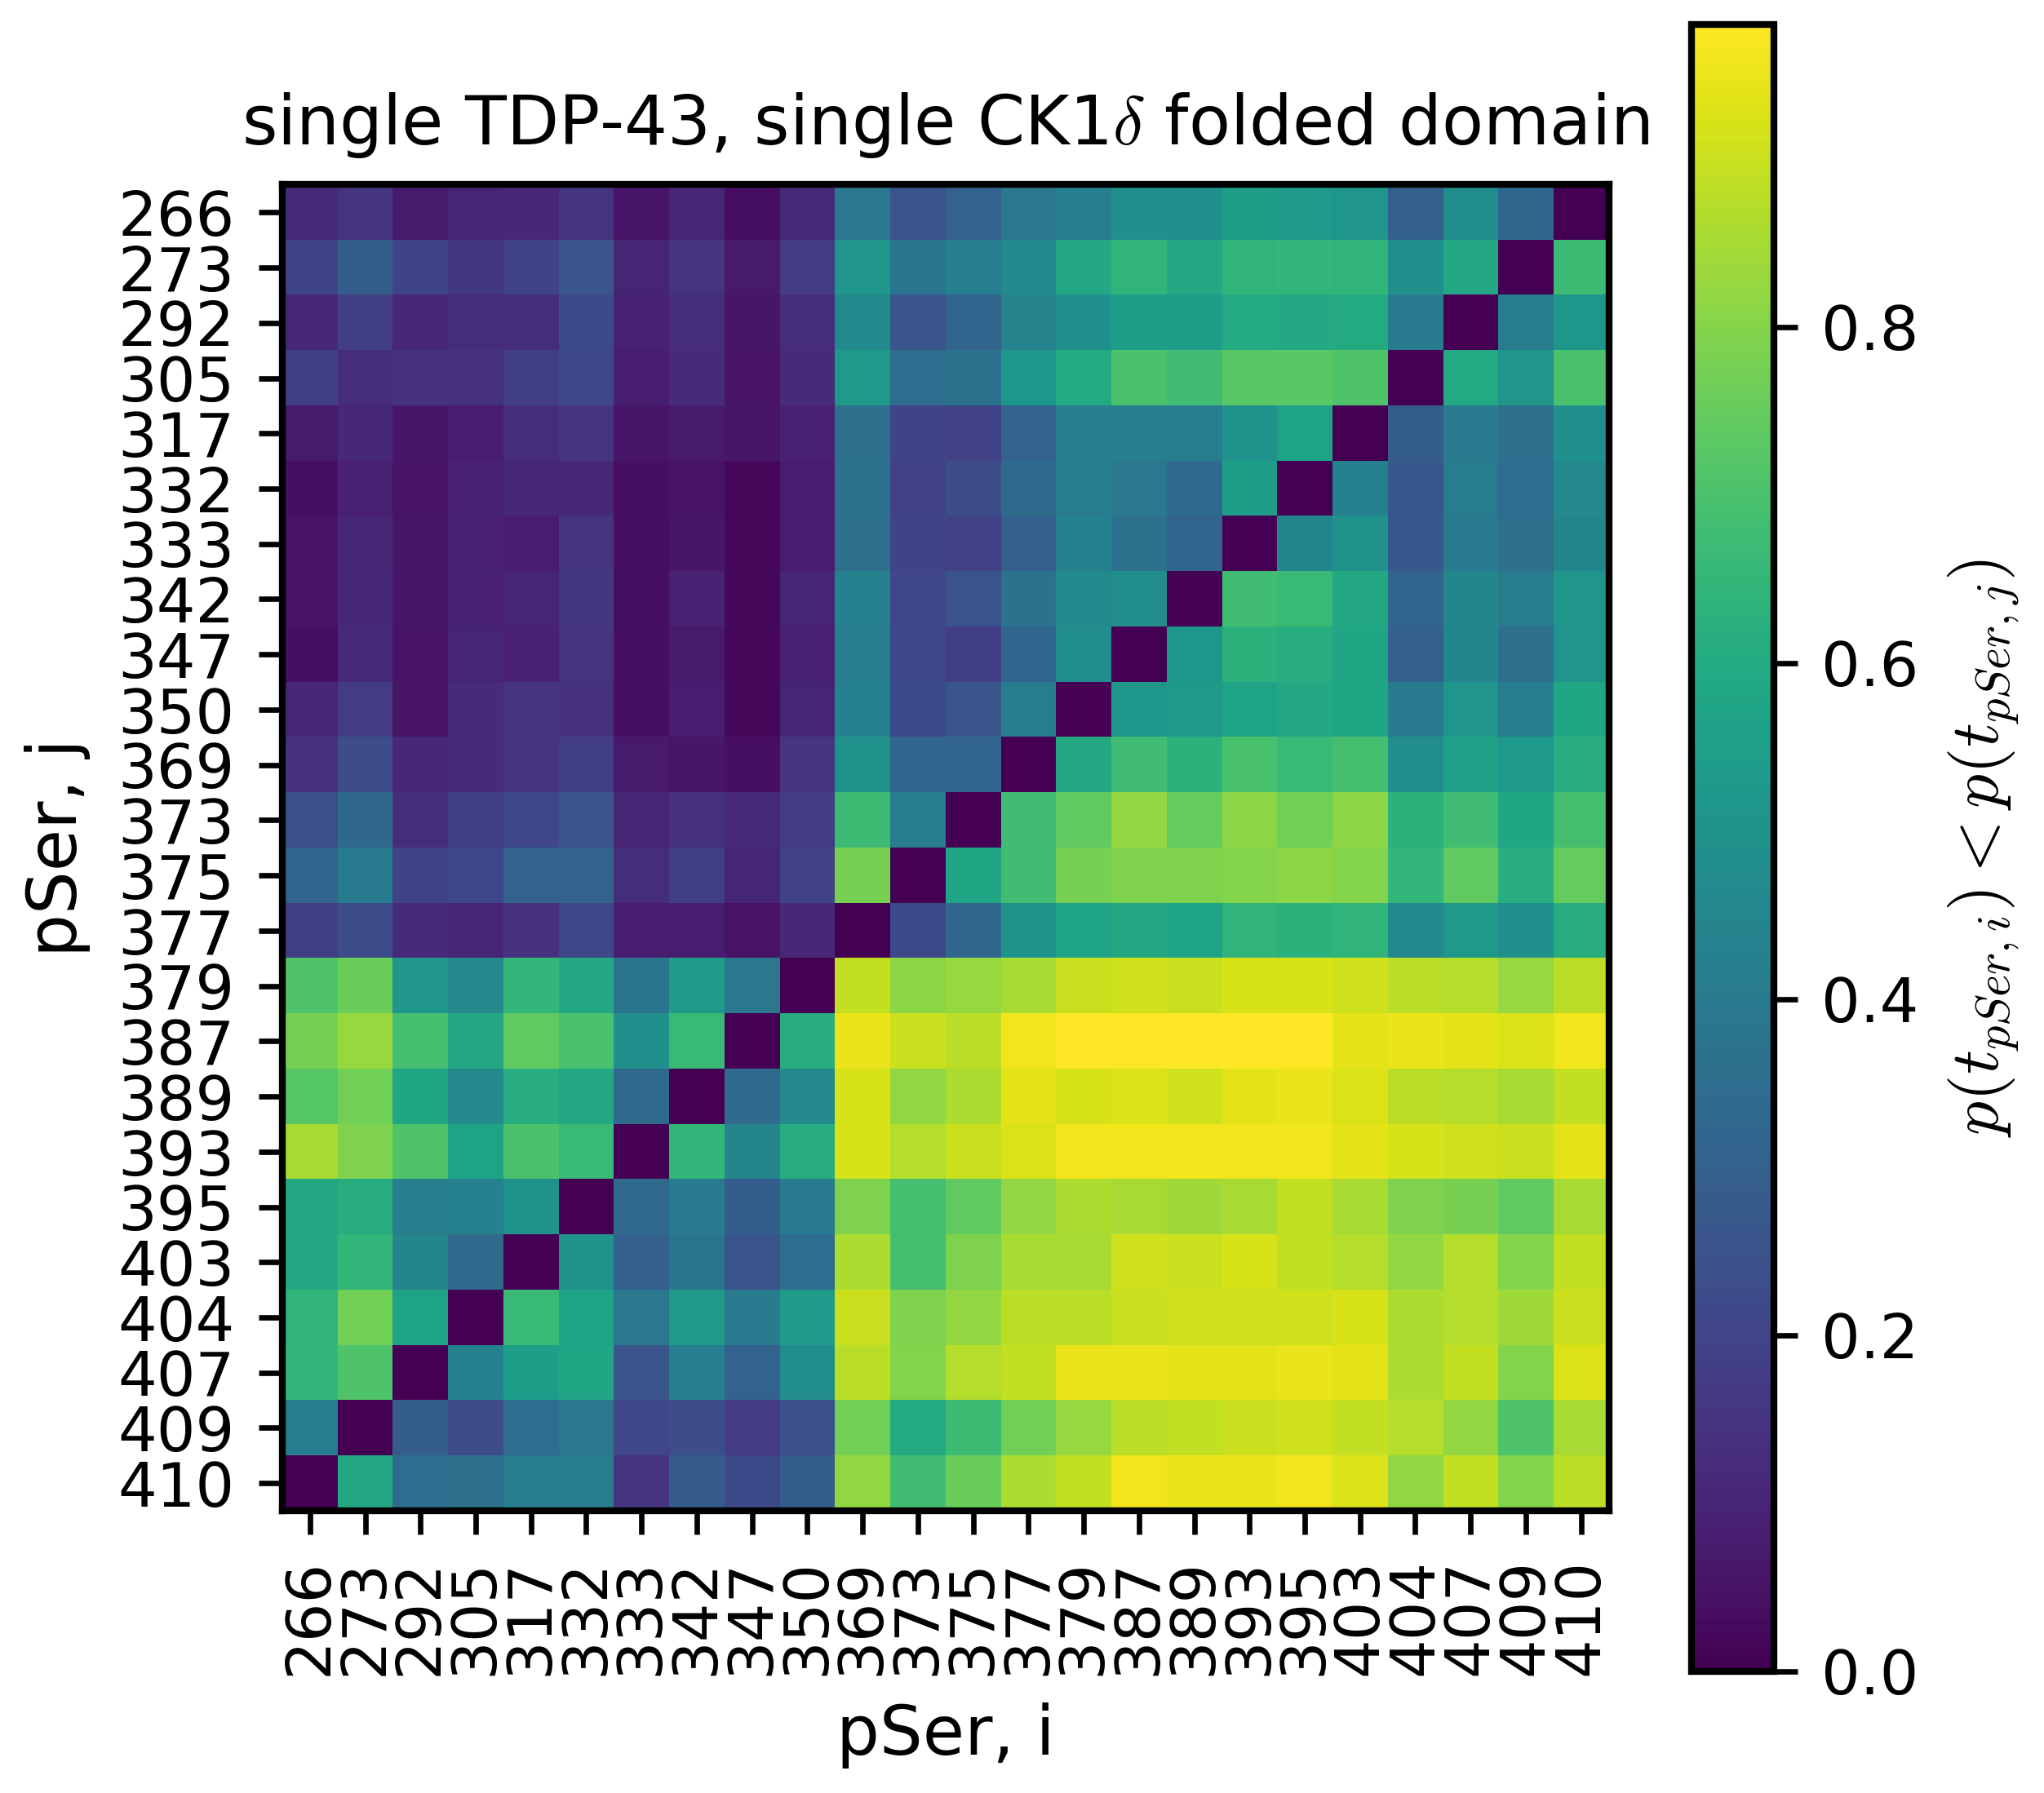

In [9]:
plt.imshow(ph_rank/100, cmap='viridis', interpolation='nearest')
color_bar = plt.colorbar()
plt.xticks(np.arange(0,24) , ser_i+260, rotation="vertical" )
plt.yticks(np.arange(0,24),
          [f"{ser_i[i]+260}" for i in range(0,24)] )
plt.xlabel('pSer, i' )
plt.ylabel('pSer, j' )
plt.title('single TDP-43, single CK1$\delta$ folded domain', fontsize=10)

color_bar.set_label(r'$p(t_{pSer,i}) < p(t_{pSer,j})$')

plt.show()

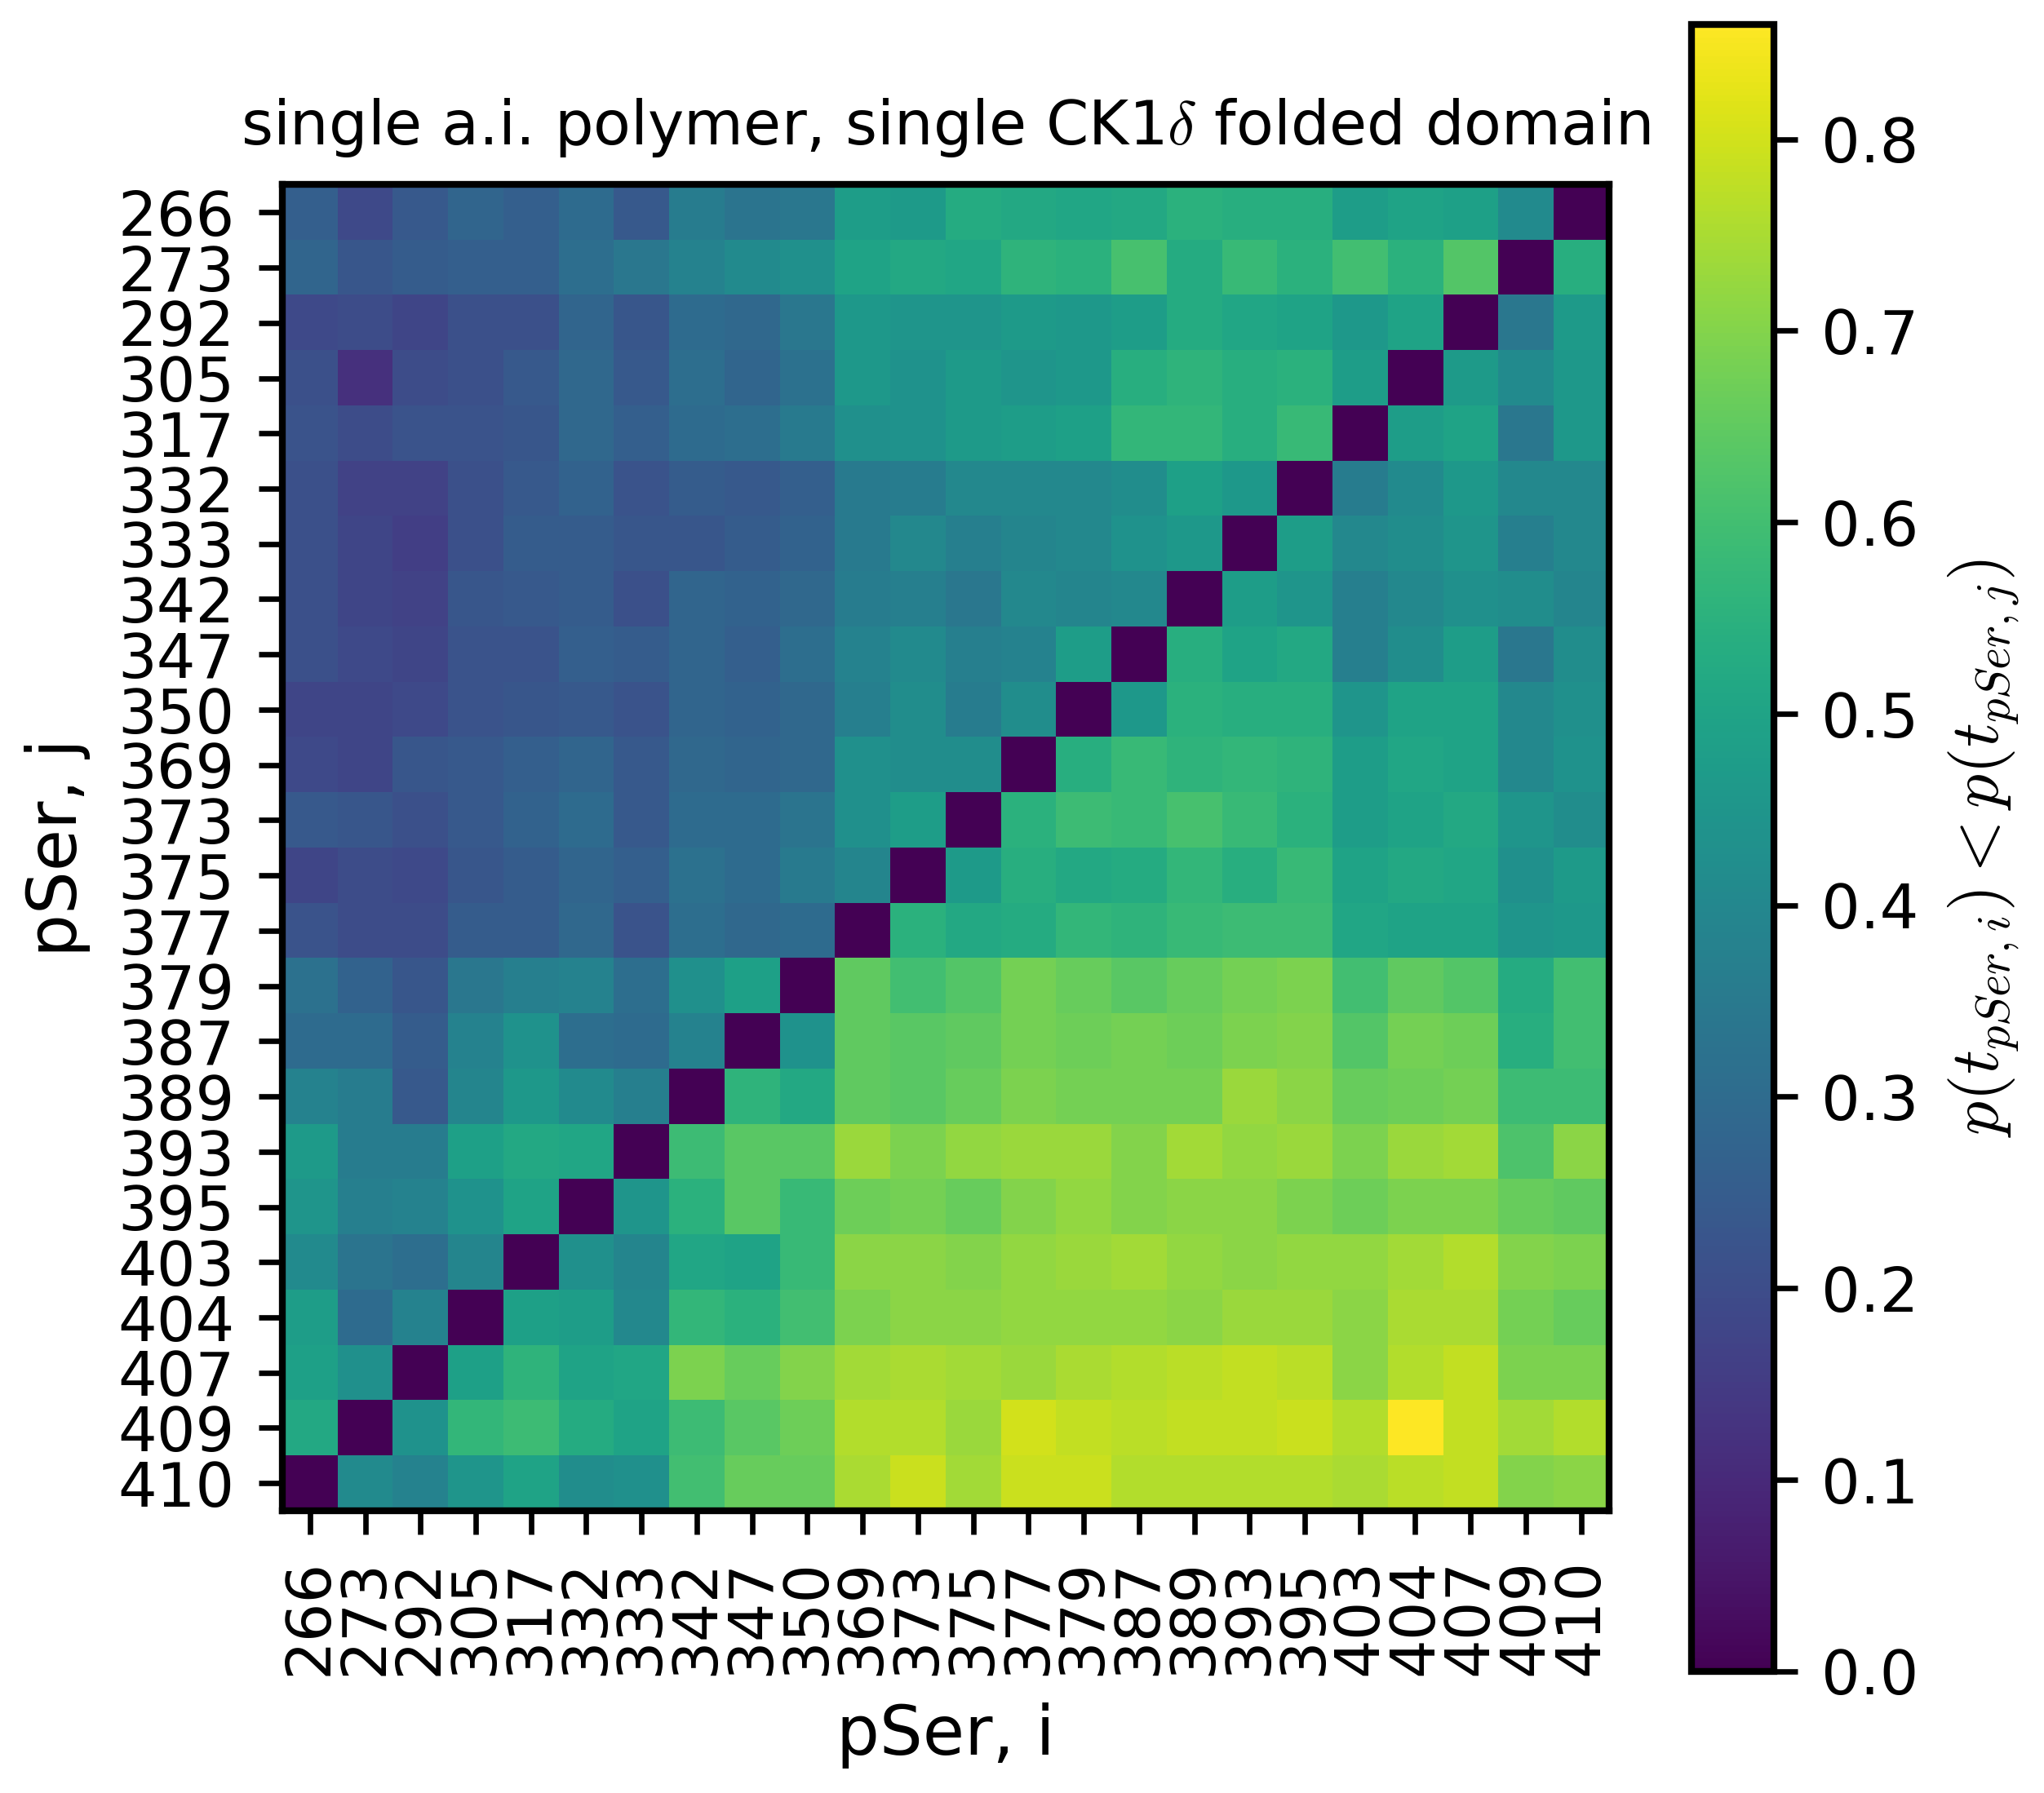

In [10]:
plt.imshow(ph_rank_h/100, cmap='viridis', interpolation='nearest')
color_bar = plt.colorbar()
plt.xticks(np.arange(0,24) , ser_i+260, rotation="vertical" )
plt.yticks(np.arange(0,24),
          [f"{ser_i[i]+260}" for i in range(0,24)] )
plt.xlabel('pSer, i' )
plt.ylabel('pSer, j' )
plt.title('single a.i. polymer, single CK1$\delta$ folded domain', fontsize=9)

color_bar.set_label(r'$p(t_{pSer,i}) < p(t_{pSer,j})$')

plt.show()

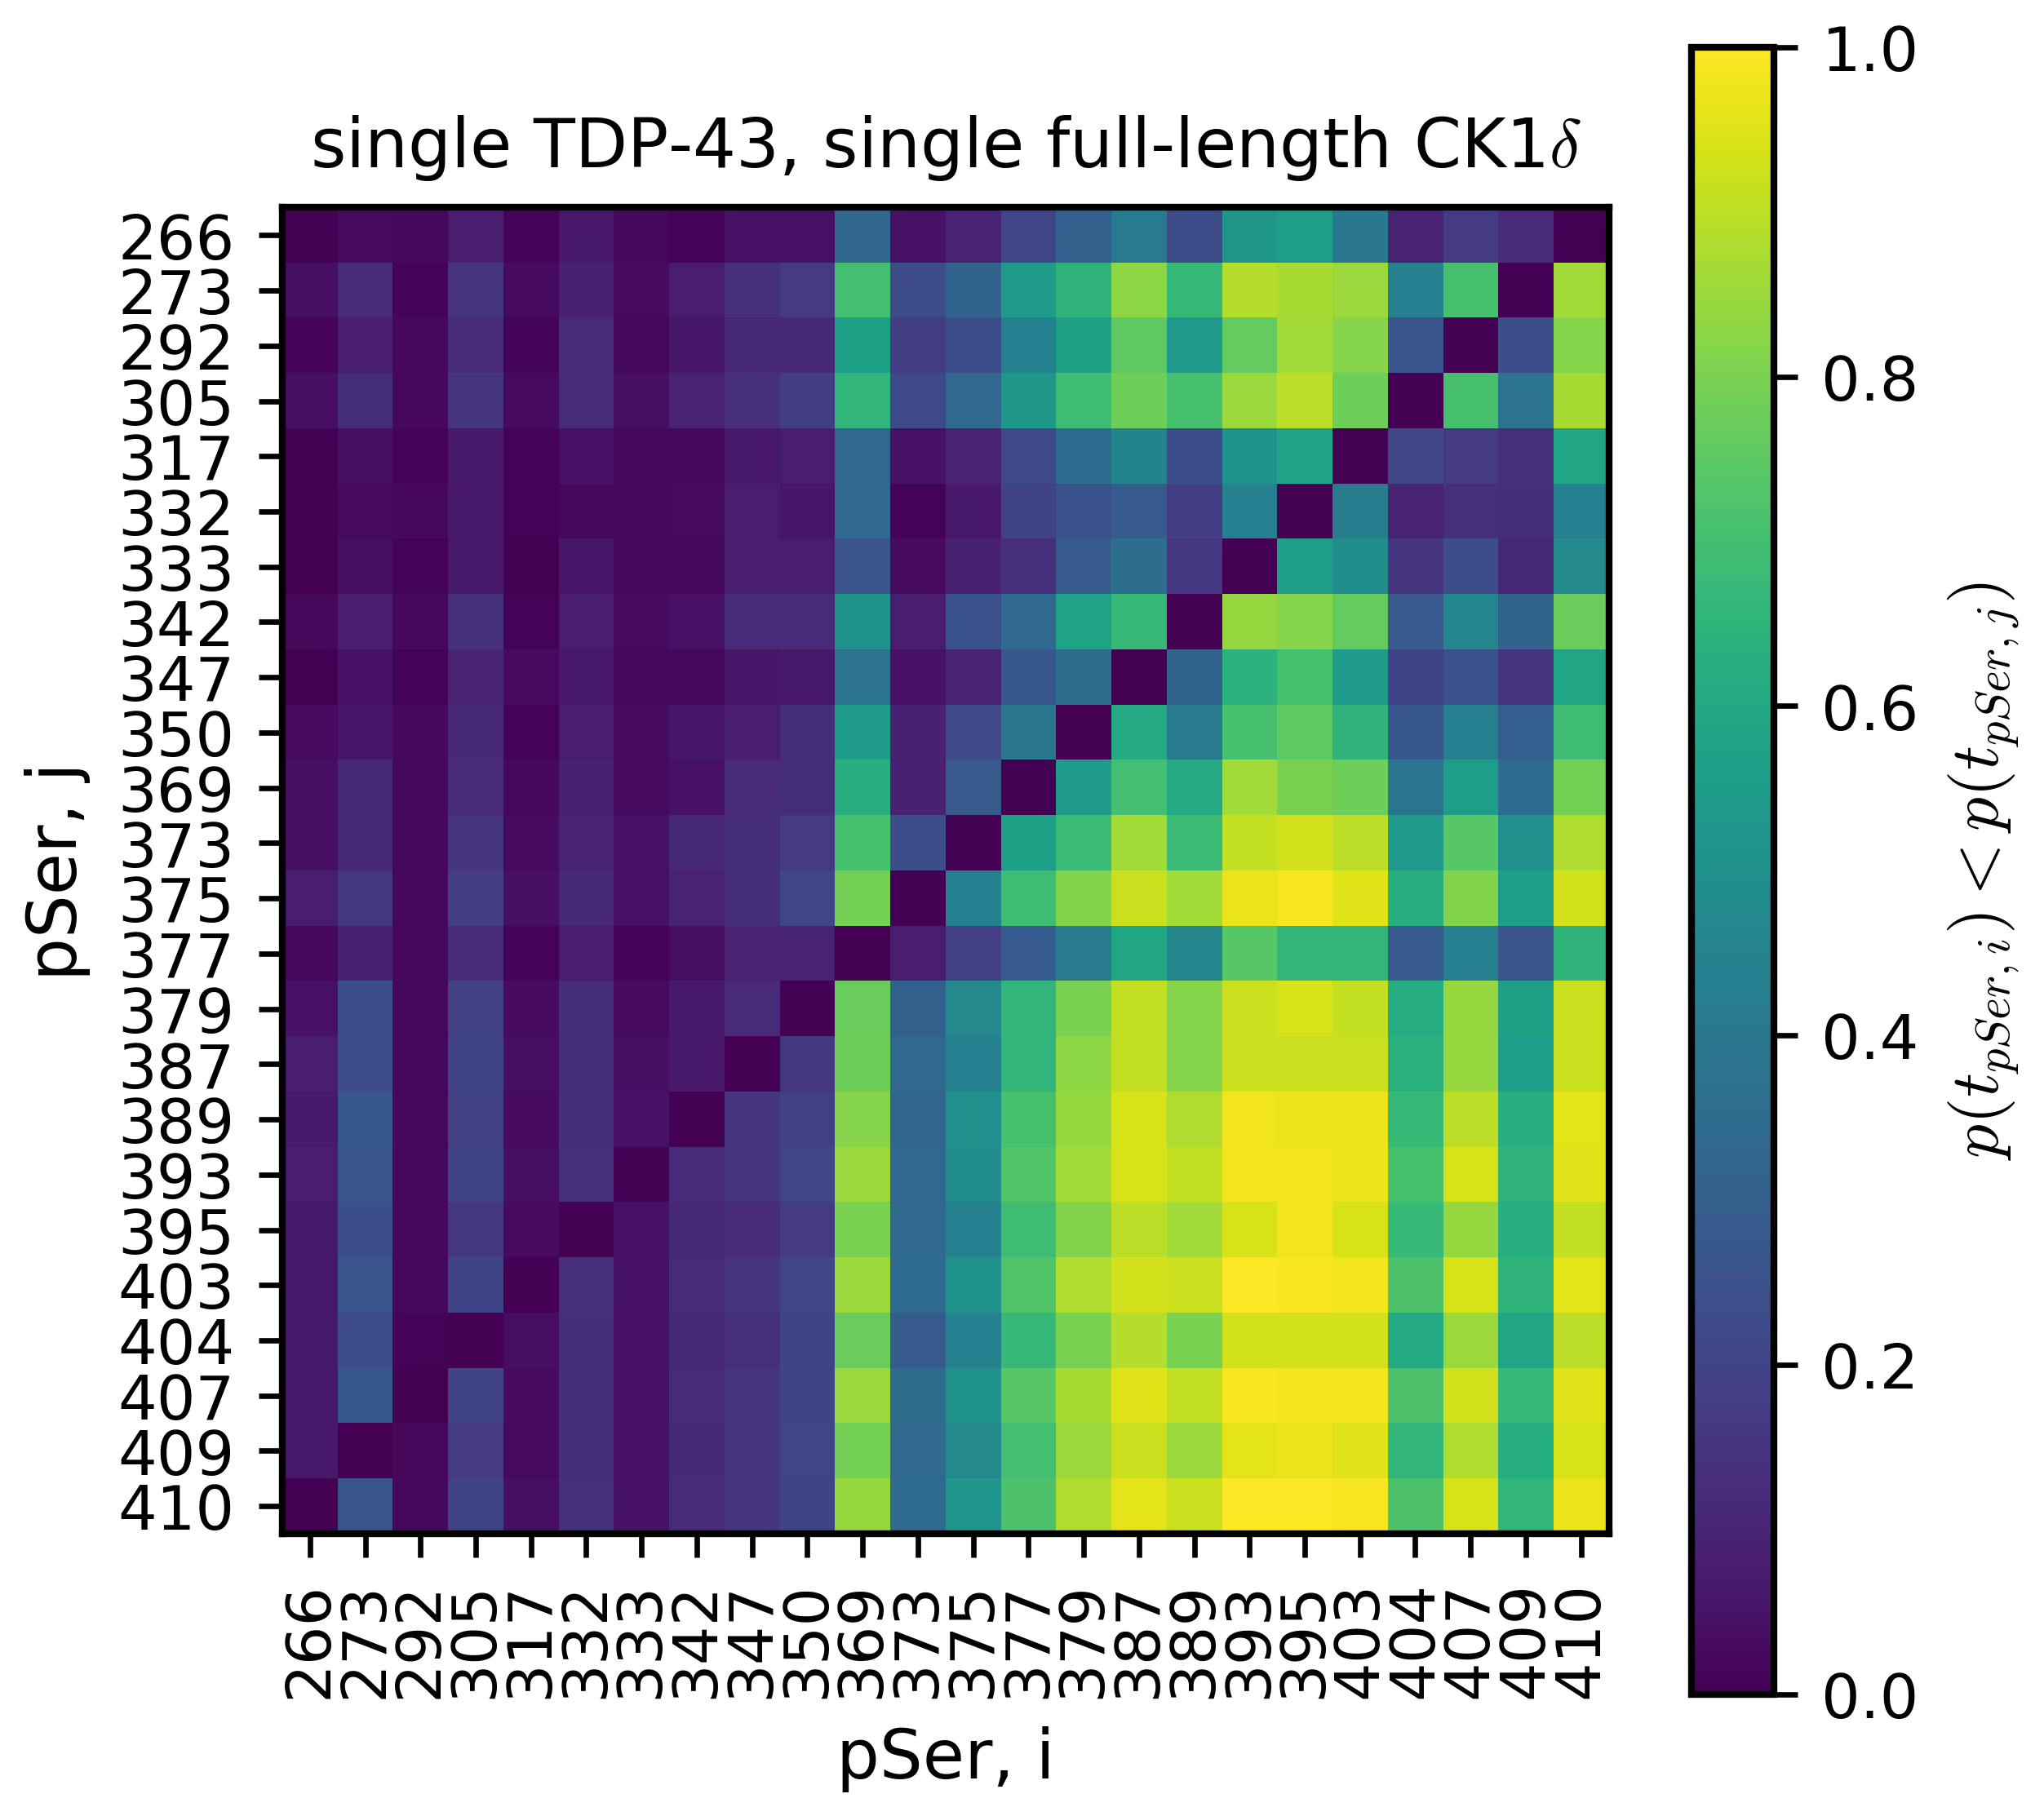

In [11]:
plt.imshow(ph_rank_f/100, cmap='viridis', interpolation='nearest')
color_bar = plt.colorbar()
plt.xticks(np.arange(0,24) , ser_i+260, rotation="vertical" )
plt.yticks(np.arange(0,24),
          [f"{ser_i[i]+260}" for i in range(0,24)] )
plt.xlabel('pSer, i' )
plt.ylabel('pSer, j' )
plt.title('single TDP-43, single full-length CK1$\delta$', fontsize=10)

color_bar.set_label(r'$p(t_{pSer,i}) < p(t_{pSer,j})$')

plt.show()

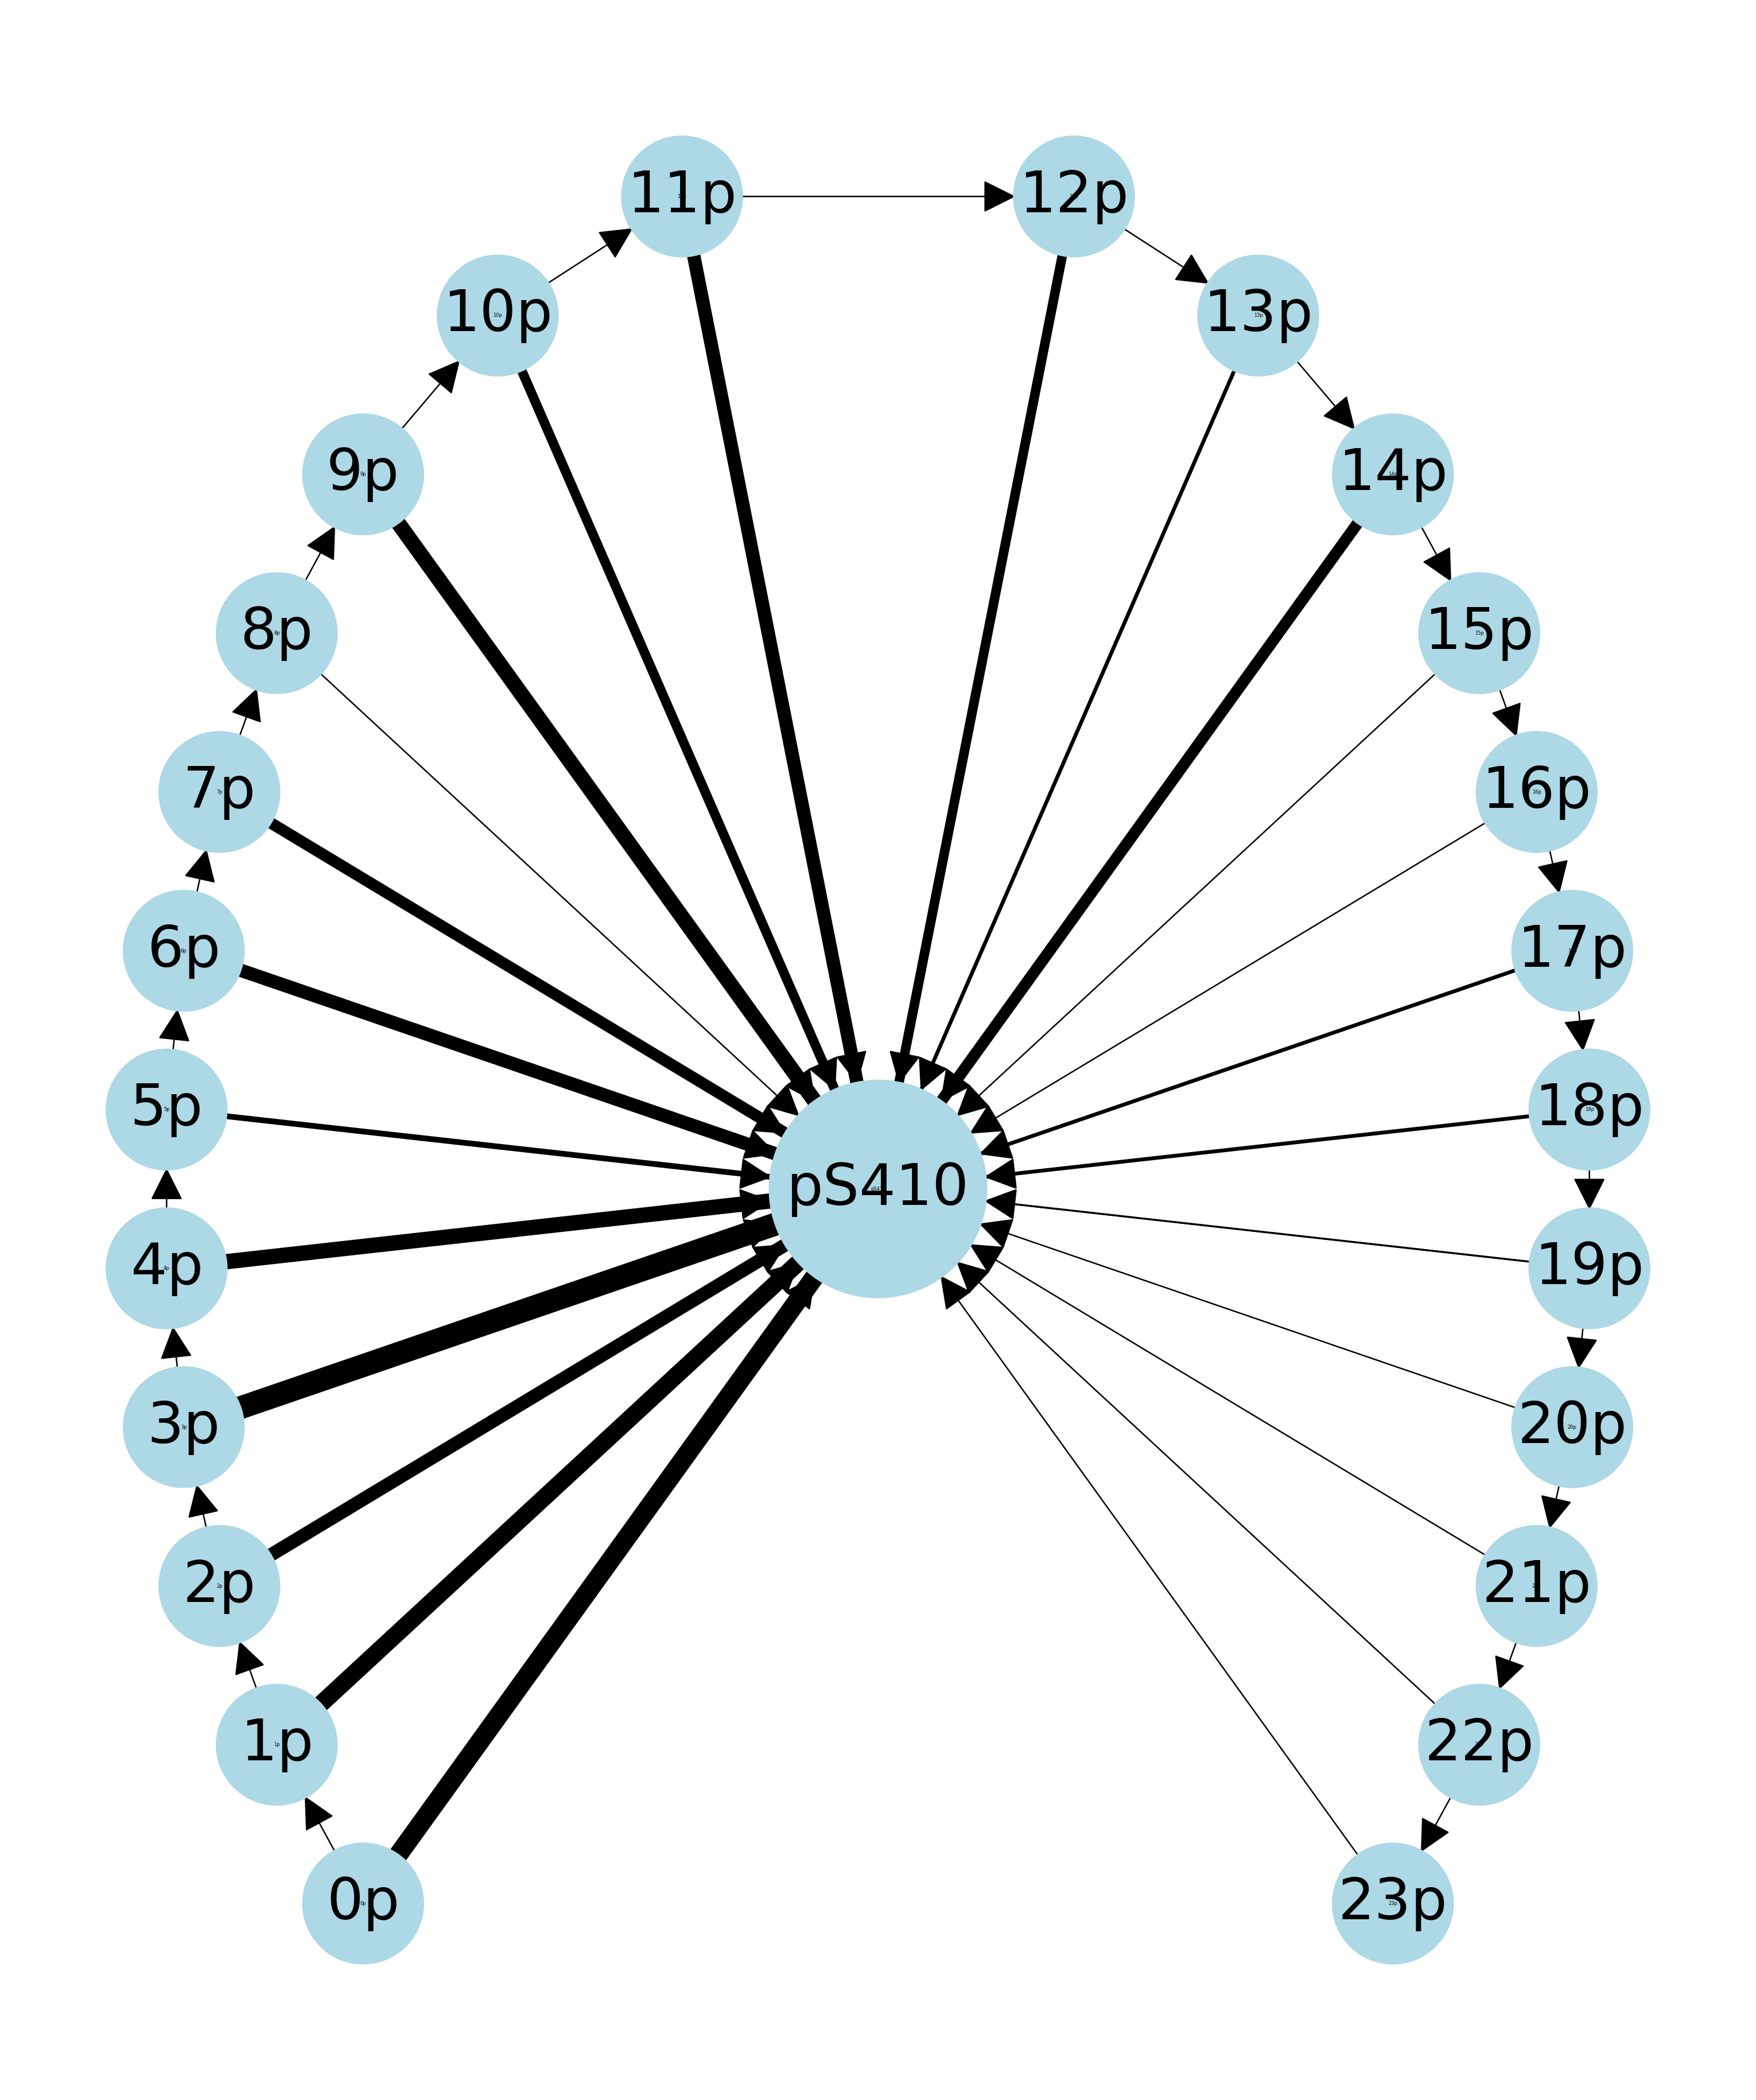

In [37]:
plot_hist_network(ph_pos, ser_i, 23)